# Домашнее задание для Junior DS по разработке PD модели

<b>Задание:</b> Необходиом разработать модель предсказания дефолта. Даны финансовые данные 32 395 компаний (выручка, активы, пассивы и т.д). Результат будет оцениваться на скрытой выборке из 200 компаний по метрике качества accuracy_score

<b>Цель задания</b> научиться / показать знания в разработке моделей оценки риска - probability of default. Задание приближено к реальному, данные синтетические. Лидерборд для оценки собственного решения и геймификации процесса обучения. Первое место в лидерборде не явлется целью. Цель - правильно разарботанная модель, удовлетворяющая требованиям банковской системы. В случае возникновения вопросов, сотрудники блока Риски готовы проконсультировать и дать обратную связь на модель (телеграм чат).

<b>Метрика качества</b> accuracy_score вычисляется, как ( True positive + True negative ) / Total. Если сабмит-файл, не правильного формата или неверное количество строк, метрика будет = 0.

### Импортируем библиотеки

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

### Подгружаем данные

In [ ]:
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-train.csv
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-test.csv
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-desc.csv

--2021-10-23 17:25:33--  https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5329268 (5.1M) [text/plain]
Saving to: ‘PD-data-train.csv.1’

PD-data-train.csv.1 100%[===================>]   5.08M  --.-KB/s    in 0.08s   

2021-10-23 17:25:33 (59.8 MB/s) - ‘PD-data-train.csv.1’ saved [5329268/5329268]

--2021-10-23 17:25:33--  https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28259

In [ ]:
train_df = pd.read_csv('PD-data-train.csv', sep=';')
test_df = pd.read_csv('PD-data-test.csv', sep=';')
desc_df = pd.read_csv('PD-data-desc.csv', sep=';')

Описание данных

In [ ]:
desc_df

,field,desc_eng,desc_rus
0,ar_revenue,Sales revenue (at the end of the last year),Выручка от реализации (на конец последнего года)
1,ar_total_expenses,Total expenses for the last year,Общие расходы за последний год
2,ar_sale_cost,Cost of sales (at the end of the last year),Себестоимость продаж (на конец последнего года)
3,ar_selling_expenses,Selling expenses (at the end of the last year),Коммерческие расходы (на конец последнего года)
4,ar_management_expenses,Administrative expenses (at the end of the las...,Управленческие расходы (на конец последнего года)
5,ar_sale_profit,Profit from sales (at the end of the last year),Прибыль от реализации (на конец последнего года)
6,ar_balance_of_rvns_and_expns,Balance of income and expenses (at the end of ...,Баланс доходов и расходов (на конец последнего...
7,ar_profit_before_tax,Gross Profit (end of last year),Валовая прибыль (на конец последнего года)
8,ar_taxes,Current income tax (at the end of the last year),Текущий на налог на прибыль (на конец последне...
9,ar_other_profit_and_losses,Other income and expenses (at the end of the l...,Прочие доходы и расходы (на конец последнего г...


Семплы и размеры выборок

In [ ]:
train_df.head()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
0,7,52996000.0,48344000.0,48344000.0,0.0,0.0,4652000.0,-2608000.0,2044000.0,846000.0,0.0,1198000.0,0.0,7240000.0,4988000.0,2252000.0,0.0,255000.0,1198000.0,663000.0,15872000.0,0.0,11349000.0,4523000.0,0.0,198,136,3,3,3,[1-100],50000.0,2,0,0,0,0
1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256,135,12,12,12,[1-100],10000.0,5,0,0,0,0
2,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,33,28,28,28,[1-100],10000.0,2,0,0,0,0
3,22,32049000.0,29568000.0,29568000.0,0.0,0.0,2481000.0,-260000.0,2221000.0,302000.0,0.0,1919000.0,0.0,4245000.0,4082000.0,163000.0,0.0,25000.0,1919000.0,2219000.0,3652000.0,0.0,3652000.0,0.0,0.0,185,139,8,8,8,[1-100],300000.0,1,0,0,0,0
4,23,16458000.0,14935000.0,14935000.0,0.0,0.0,1523000.0,-274000.0,1249000.0,538000.0,0.0,711000.0,0.0,8950000.0,8606000.0,344000.0,0.0,492000.0,711000.0,12439000.0,1279000.0,0.0,0.0,1279000.0,0.0,220,138,27,27,27,[1-100],10000.0,2,0,0,0,0


In [ ]:
test_df.head()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg
0,196,39103000.0,38913000.0,38913000.0,0.0,0.0,190000.0,141000.0,331000.0,284000.0,0.0,47000.0,0.0,6009000.0,2451000.0,3558000.0,0.0,677000.0,47000.0,1178000.0,6130000.0,0.0,3000000.0,3130000.0,0.0,156,135,3,3,3,[1-100],100000.0,1,0,0,0
1,1196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216,138,5,5,5,[1-100],100000.0,1,0,0,0
2,2813,54174000.0,50929000.0,50929000.0,0.0,0.0,3245000.0,-1278000.0,1967000.0,500000.0,0.0,1467000.0,0.0,8175000.0,8037000.0,138000.0,0.0,237000.0,1467000.0,6835000.0,3906000.0,0.0,0.0,3906000.0,0.0,244,138,20,20,20,[1-100],250000.0,2,0,0,0
3,4385,1904000.0,1679000.0,1679000.0,0.0,0.0,225000.0,-88000.0,137000.0,0.0,0.0,137000.0,0.0,5790000.0,4314000.0,1476000.0,0.0,35000.0,137000.0,5691000.0,540000.0,0.0,500000.0,40000.0,0.0,272,139,9,9,9,[1-100],10000.0,2,0,0,0
4,6479,225584000.0,210685000.0,210685000.0,0.0,0.0,14899000.0,-12715000.0,2184000.0,445000.0,0.0,1739000.0,0.0,65485000.0,46006000.0,19479000.0,0.0,956000.0,1739000.0,12408000.0,47017000.0,0.0,16215000.0,30802000.0,0.0,254,139,3,3,3,(100-500],1700598.0,84,0,0,0


Построим матрицу корреляций всех переменных


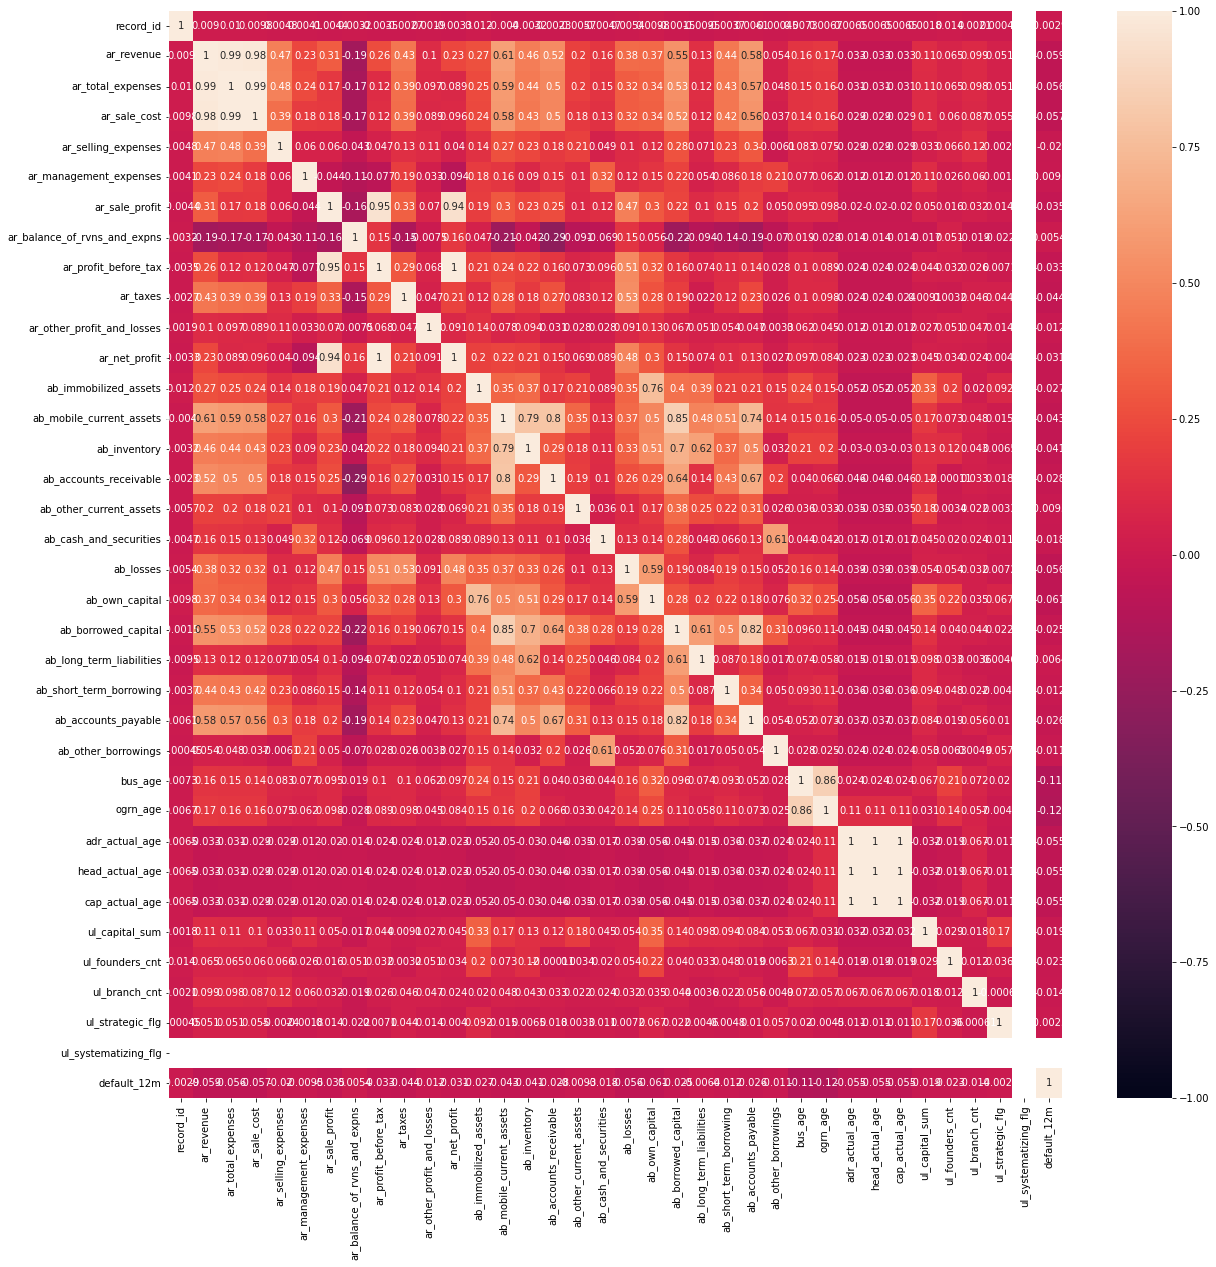

In [ ]:

plt.subplots(figsize=(20,20))
sns.heatmap(train_df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

Наблюдается мультиколлинеарность в обучающей выборке. Необходимо убрать некоторые признаки, имеющие одинаковое влияние на результат

In [ ]:
train_df = train_df.drop(['ar_revenue', 'ar_total_expenses', 'ar_sale_cost', 'ar_selling_expenses', 'ar_management_expenses',
         'ar_sale_profit', 'ar_balance_of_rvns_and_expns','ul_staff_range', 'ar_profit_before_tax', 'ar_taxes', 
         'ar_other_profit_and_losses', 'ul_systematizing_flg','ul_strategic_flg','ab_mobile_current_assets', 'bus_age', 'ab_immobilized_assets', 'ab_inventory','ab_borrowed_capital'], axis = 1)

In [ ]:
features = ['adr_actual_age','ul_capital_sum', 'ul_founders_cnt','ogrn_age',]#'ar_net_profit','ab_accounts_receivable','ab_losses']

In [ ]:
features_df = train_df.loc[:,features]
features_df['default_12m'] = train_df['default_12m']

Посмотрим на итоговую тепловую карту корреляций

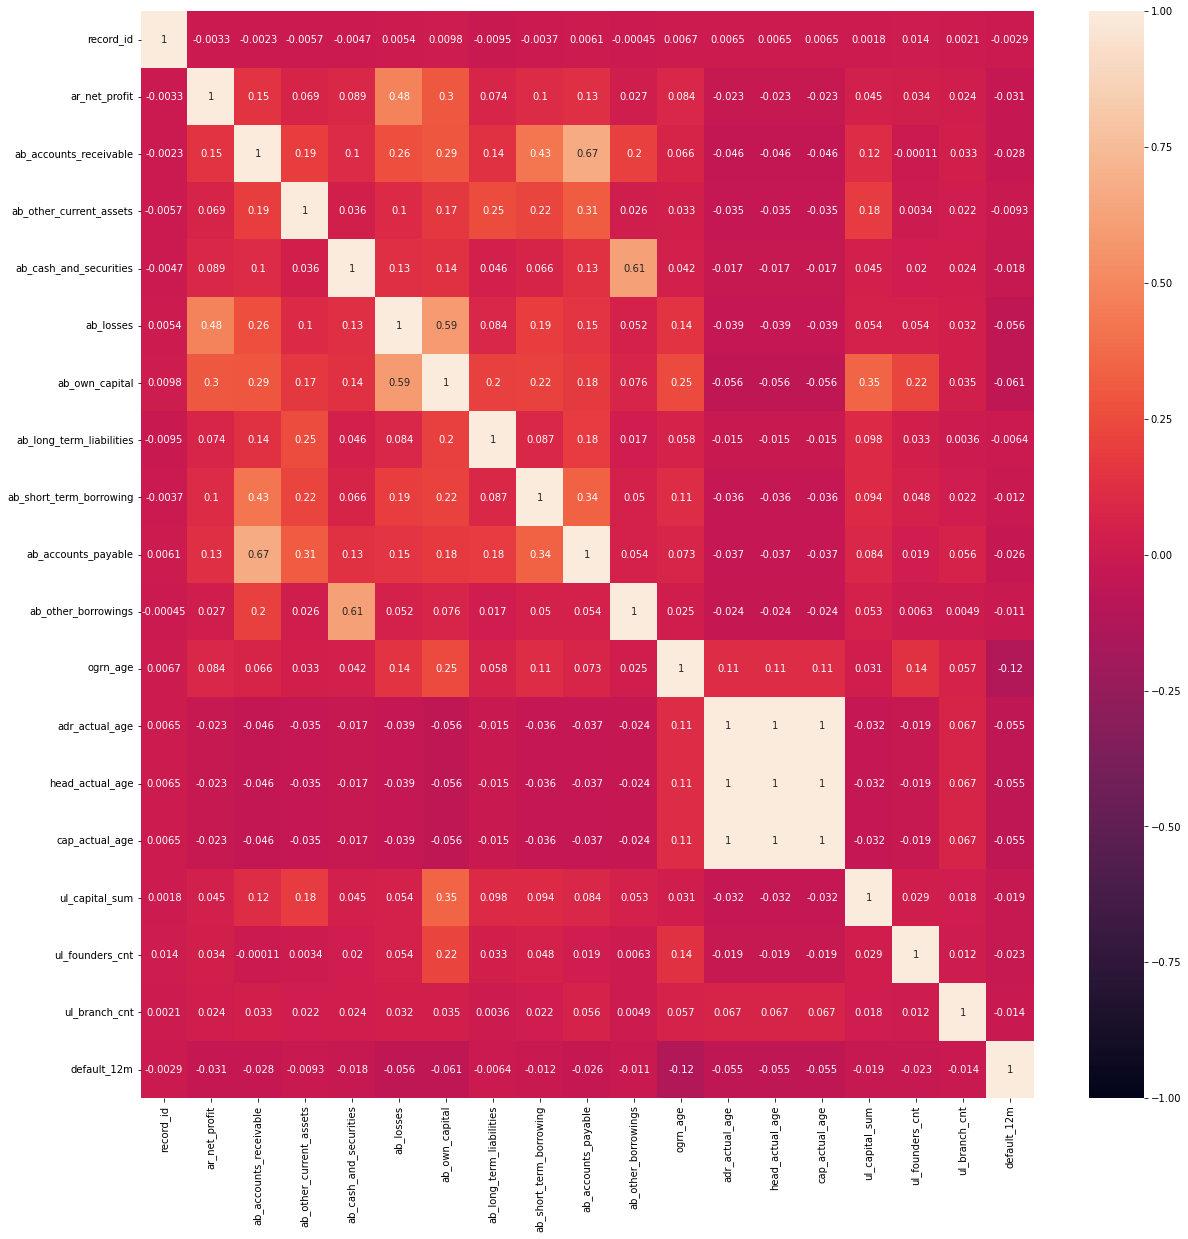

In [ ]:
plt.subplots(figsize=(20,20))
sns.heatmap(train_df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

У всех отобранных переменных коэффициент корреляции меньше 0,05

In [ ]:
features_df.corr()

,adr_actual_age,ul_capital_sum,ul_founders_cnt,ogrn_age,default_12m
adr_actual_age,1.000000,-0.032239,-0.018616,0.112917,-0.055146
ul_capital_sum,-0.032239,1.000000,0.029165,0.031248,-0.019452
ul_founders_cnt,-0.018616,0.029165,1.000000,0.135324,-0.023244
ogrn_age,0.112917,0.031248,0.135324,1.000000,-0.121140
default_12m,-0.055146,-0.019452,-0.023244,-0.121140,1.000000


BaseLine модели составляет 65,3 %, что говорит о том, данная модель средняя по качеству и не объесняет все факторы, приводящие к дефолту. 





In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_df.drop('default_12m',axis=1),
                                                    features_df['default_12m'],
                                                    random_state=42, shuffle=True)

logit = LogisticRegression(multi_class='ovr',C=1,solver='liblinear',penalty = 'l1',max_iter=1000)
cv_baseline = cross_val_score(logit, X_train, y_train, cv=5, scoring='roc_auc').mean()
cv_baseline

0.6539181614203999

In [ ]:
logit.fit(features_df.drop('default_12m',axis=1), features_df['default_12m'])

Формируем файл с ответами

In [ ]:
answ_df = test_df[['record_id']]

In [ ]:
answ_df['id'] = answ_df['record_id']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
answ_df.drop('record_id',axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
cutoff = y_train.mean()

In [ ]:
answ_df['predict'] = (logit.predict_proba(test_df.loc[:,features])[:,1]>cutoff).astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
answ_df.to_csv('PD-submit.csv',index=False, sep=';')